In this notebook, I will implement *Boosting* based on decision trees, specifically Gradient Boosting and `XGBoost`. Similar to *Bagging*, *Boosting* is a general approach that can be applied to many machine learning methods. Trees in Boosting are built **sequentially**: each tree is grown using info from previously grown trees. Boosting, notably, does not involve bootstrap sampling and instead is fit on a modified version of the original data set.

Boosting learns *slowly*. Given the current model, we fit a decision tree to the residuals from the model instead of $Y$ (hospital charges). When then add this new decision tree into the fitted function in order to update the residuals. By fitting small trees to the residuals, we slowly improve $\hat{f}$ in areas where it does not perform well. The shrinkage parameter $\lambda$ slows the process down further, allowing more and different shaped trees to attack the residuals.

**Algorithm:**:

1. Set $\hat{f}(x) = 0$ and $r_i = y_i$, $\forall i $ in the training set 
2. For $b = 1, 2, \dots, B$, repeat:
    1. Fit a tree $\hat{f}^b$ with $d$ splits ($d+1$ terminal nodes) to the training data ($X,r$)
    2. Update $\hat{f}$ by adding in a shrunken version of the new tree: $\hat{f}(x) \leftarrow \hat{f}(x) + \lambda \hat{f}^b(x)$
    3. Update the residuals: $r_i \leftarrow r_i - \lambda  \hat{f}^b(x_i)$
    4. Output the boosted model: $\hat{f}(x) = \sum_{b=1}^{B} \lambda  \hat{f}^b(x)$
    
Boosting here has three hyperparameters (tuning parameters):
1. The number of trees $B$. Unlike *bagging* and *random forests*, boosting can overfit if $B$ is too large. We will use cross-validation to select $B$
2. The shrinkage parameter $\lambda$, a small positive number. This controls the rate at which boosting learns. Typical values are 0.01 or 0.001. Very small $\lambda$ will require large number of trees $B$
3. The number of $d$ splits in each tree which controls the complexity of the boosted ensemble. $d=1$ often works well in which each tree is a *stump*, consisting of a single split. $d$ is also the *interaction depth* and controls the interaction order of the boosted model since $d$ splits can involve at most $d$ variables.
    - maximum depth of each individual tree in the ensemble

Because of $d$, the ensemble $\hat{f}$ is usually built by combining predictions of many small trees

**SOURCE**: Introduction to Statistical Learning (Python)

In [13]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, median_absolute_error

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Importing Dataset

In [15]:
# Importing processed dataframe
path_project = "C:/Users/Conno/Documents/Career/Projects/Hospital_Charges/tree_based_models"

os.chdir(path_project)
plots_dir = 'boosting_plots' # stores plots in plot folder

df = pd.read_csv("../df_processed.csv")

# do this later in data_cleaning file
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

#df.dtypes

## Train-Test Split

In [16]:
X = df.drop(columns = ["charges"])
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 32)

# Gradient Boosting

In [6]:
boosting_model = GradientBoostingRegressor()

In [20]:
# 5 fold cross validation for hyperparameter tuning with the training set

param_grid_boost = {
    'n_estimators': [100, 500, 1000, 5000], # num trees: B
    'learning_rate': [0.01, 0.001], # learning rate: lambda
    'max_depth': [1, 3, 5], # num splits: d
    'random_state': [32]
}

grid_boost = GridSearchCV(estimator = boosting_model,
                         param_grid = param_grid_boost,
                         cv = 5,
                         scoring = 'neg_mean_squared_error',
                         n_jobs = -1
                         )

grid_boost.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.001], 'max_depth': [1, 3, 5],
                         'n_estimators': [100, 500, 1000, 5000],
                         'random_state': [32]},
             scoring='neg_mean_squared_error')

In [11]:
print("Best Parameters from Grid Search: ", grid_boost.best_params_)
print("Best Cross-Validation Score from Grid Search: ", -grid_boost.best_score_)

Best Parameters from Grid Search:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 5000, 'random_state': 32}
Best Cross-Validation Score from Grid Search:  3093706346.151949


## Plotting

In [22]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

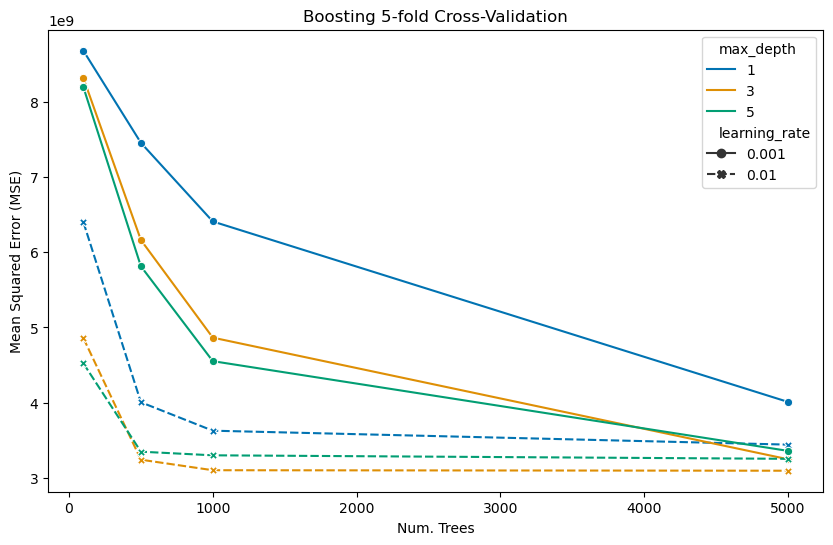

In [38]:
# creating a dataframe of the results and extracting the key columns necessary for plotting

results_boost = pd.DataFrame(grid_boost.cv_results_)
results_boost = results_boost[['param_n_estimators', 'param_learning_rate', 'param_max_depth', 'mean_test_score']]
results_boost.columns = ['n_estimators', 'learning_rate', 'max_depth', 'mean_test_score']
results_boost['mean_test_score'] = -results_boost['mean_test_score']

plt.figure(figsize=(10, 6))
sns.lineplot(data = results_boost,
            x = 'n_estimators',
            y = 'mean_test_score',
            hue = 'max_depth',
            style = 'learning_rate',
            markers = True,
            dashes = True,
            palette='colorblind')

plt.xlabel('Num. Trees')
plt.ylabel('Mean Squared Error (MSE)')
plt.title("Boosting 5-fold Cross-Validation")

boost_cv_path = os.path.join(plots_dir, 'boost_cv_plot')
plt.savefig(boost_cv_path)

plt.show()

The learning rate of $0.0001$ converges much slower as the number of trees increases, however it does eventually reach similar performance to 0.01. Nevertheless, 0.01 is clearly better from the performed cross-validation. A max depth of 3 splits was also optimal. The model's performance improves with an increasing number of trees for all configurations but the rate of improvement diminishes. It stabilizes at 1000 trees and would be more computationally efficient than 5000 trees.

Thus the chosen hyperparameters will be:
- $B = 1000$
- $\lambda = 0.01$
- $d$ = 3

In [45]:
t0 = time.time()

final_boost_model = GradientBoostingRegressor(n_estimators = 1000, # B
                                             learning_rate = 0.01, # lambda
                                             max_depth = 3, # d
                                             random_state =32)
final_boost_model.fit(X_train, y_train)

t1 = time.time()

t = t1 - t0

print(f"Time to fit the model: {t:.2f} seconds")

Time to fit the model: 10.10 seconds


## Feature Importance

The feature importance scoring criteria is *purity* where it refers to the relative importance of each feature (predictor) in predicting the target variable (hospital charges). This metric is derived from the contribtion of each feature to the reduction of the loss function (mse) across all the trees in the ensemble

In [46]:
boost_fi = final_boost_model.feature_importances_

boost_fi_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': boost_fi
}).sort_values(by = 'Importance', ascending = False)

boost_fi_df

,Feature,Importance
3,slos,0.383344
13,hday,0.234973
18,dnrday,0.118217
8,avtisst,0.085204
0,age,0.030399
7,scoma,0.030192
10,aps,0.023191
20,wblc,0.018905
6,edu,0.011866
39,race_hispanic,0.011545


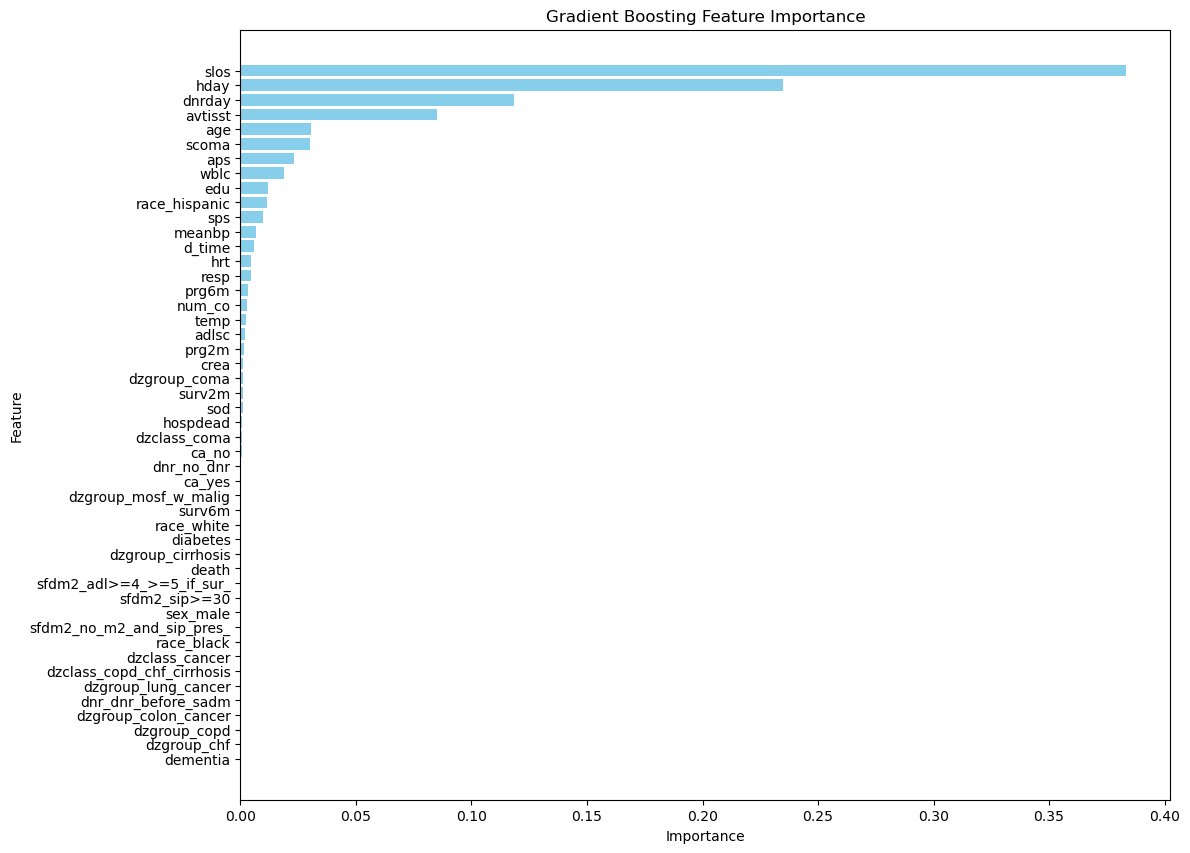

In [53]:
plt.figure(figsize = (12, 10))
plt.barh(boost_fi_df["Feature"], boost_fi_df["Importance"], color = 'skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Gradient Boosting Feature Importance')
plt.gca().invert_yaxis()

boost_fi_path = os.path.join(plots_dir, 'boost_fi_plot')
plt.savefig(boost_fi_path)

plt.show()

## Predicting Test Set

In [37]:
y_pred_bst = final_boost_model.predict(X_test)

bst_mape = mean_absolute_percentage_error(y_test, y_pred_bst)
bst_mae = mean_absolute_error(y_test, y_pred_bst)
bst_mdae = median_absolute_error(y_test, y_pred_bst) # median absolute error
bst_mse = mean_squared_error(y_test, y_pred_bst)
bst_rmse = rmse(y_test, y_pred_bst)

print("Gradient Boosting MAPE:", round(bst_mape, 4))
print("Gradient Boosting MAE:", round(bst_mae, 4))
print("Gradient Boosting MDAE:", round(bst_mdae, 4))
print("Gradient Boosting MSE:", round(bst_mse, 4))
print("Gradient Boosting RMSE:", round(bst_rmse, 4))

Gradient Boosting MAPE: 0.5056
Gradient Boosting MAE: 23120.0134
Gradient Boosting MDAE: 8212.0107
Gradient Boosting MSE: 3362682102.8773
Gradient Boosting RMSE: 57988.6377


# XGBoost

XGBoost stands for "eXtreme Gradient Boosting" and it is a specific implementation of the gradient boosting method. The two most important changes are:

1. computing second order derivatives
    1. Gradient boosting uses the loss function of the base model (e.g decision tree) as a proxy for minimizing the error of the overall model, XGBoost uses the 2nd order derivative as an approximation.
    2. Uses L1 and L2 regularization to improve model generalization.
    
XGBoost has become an industry standard in the data science community and, to put it crudely, is the silver bullet in the data science toolkit. This is because training is very fast, can be distributed across compute clusters, and has achieved state of the art perfromance in several competitions. The beauty behind it is not just its accuracy but its scalability.

XGBoost also handles sparse data in an effective way (`NA` data) thus we will be using testing the algorithm with the processed dataset AND the full, unclean dataset.

## Mathematics

In XGBoost, the objective function is:

$$\mathcal{L}(\phi) = \sum_{i}l(\hat{y}_i, y_i) + \sum_{k}\Omega(f_k)$$

$$\Omega(f) = \gamma T + \frac{1}{2}\lambda \lVert w \rVert^2$$

Where $l$ is a differentiable convex loss function measuring the difference between the true and predicted values. XGBoost creates trees by optimizing (minimizing) this objective as much as possible.

The second term $\Omega$ is the regularization term for the k-th tree (penalizes the complexity of the model). The regularization term helps smooth the final learnt weights to avoid overfitting. 
- $T$ is the number of terminal nodes in the tree $f$. 
- $\gamma$ is the regularization parameter that penalizes the number of leaves in a tree (prunes the tree). 
- $w$ represents the vector of leaf weights (the "output" or "prediction" values at the leaves)
- $\lVert w \rVert^2$ is the sum of squared weights. 
- $\lambda$ is a regularization parameter that penalizes large weights, encouraging the model to keep the leaf values smaller and thereby reducing the risk of overfitting. For XGBoost, it seems that $\lambda$ refers to L2 regularization and $\alpha$ would refer to L1 regularization. 

XGBoost's more sophisticated regularization framework allows for better control over the complexity of the model, which leads to improved generalization and reduced risk of overfitting.

Traditional optimization methods, such as gradient descent, operate in Euclidean space (x, y, z coordinates, etc). These methods typically involve optimizing a funtion with repsect to a set of parameters, where the parameters are represented as points in Euclidean space. XGBoost includes not only parameters in Euclidean space but also functions, specifically decision trees. Decision trees are more complex structures that cannot be eaily optimized using tradional methods designed for Euclidean space. This is because the tree structure as parameters (optimizing over trees involves discrete choices, not a continious process moving in Euclidean space). Also because the process of growing trees involves non-differentiable operations such as choosing the best split based on some criterion (e.g., information gain, Gini impurity). 

Instead of optimizing over the entire tree structure at once, XGBoost uses an additive approach where a model is built incrementally, like normal gradient boosting. 

### Algorithm

1. Start with an initial prediction, e.g. the mean of $y$

2. At each iteration, a new tree $f_t$ is added to the model. The objective function at iteration $t$ is given by:

$$\mathcal{L}^{(t)} = \sum_{i = 1}^{n} l(y_i, \hat{y}_i^{(t-1)}) + f_{t}(x_i)) + \Omega(f_t)$$

3. For optimization, XGBoost uses first and second order Taylor expansion (gradient and Hessian) of the loss function to approximate the objective:

$$ \mathcal{L}^{(t)} \approx \sum_{i = 1}^{n} l(y_i, \hat{y}_i^{(t-1)}) + g_{i}f_{t}(x_i) + \frac{1}{2}h_{i}f_{t}^{2}(x_i)) + \Omega(f_t)$$

$$g_i = \frac{\partial l(y_i, \hat{y}_i)}{\partial \hat{y}_i} , h_i = \frac{\partial^2 l(y_i, \hat{y}_i)}{\partial \hat{y}_i^2}$$

This approximation allows XGBoost to apply a form of gradient-based optimization but specifically tailored to the structure of decision trees.

In our case, the loss function $l(y_i, \hat{y}_i)$ is $1/2$ times the *Sum of Squared Residuals* (SSR) as we are using regression. The $1/2$ term is included for the sake of mathematical convenience when computing the gradient and hessian. For the classification part of the project (done in `R`), the loss function would be log loss if binary and cross-entropy for multi-class. 

$$l(y_i, \hat{y}_i) = \frac{1}{2}(y_i - \hat{y}_i)^2$$

which means:

$g_i = \hat{y}_i - y_i$ and $h_i = 1$

Thus our loss objective simplifies to:

$$  \mathcal{L}^{(t)} \approx \sum_{i = 1}^{n} l(y_i, \hat{y}_i^{(t-1)}) + (\hat{y}_i^{(t-1)} - y_i)f_{t}(x_i) + \frac{1}{2}f_{t}^{2}(x_i)) + \Omega(f_t)$$

Since $l(y_i, \hat{y}_i^{(t-1)})$ does not depend on $f_t(x_i)$, it can be dropped from the optimization process. Thus the loss objective can then be written completely as:

$$\mathcal{L}^{(t)} \approx \sum_{i = 1}^{n} \left[ (\hat{y}_i^{(t-1)} - y_i)f_{t}(x_i) + \frac{1}{2}f_{t}^{2}(x_i) \right] + \gamma T + \frac{1}{2}\lambda \sum_{j = 1}^{T}w_j^2$$

$(\hat{y}_i^{(t-1)} - y_i)$ represents the residuals from the previous prediction and $f_t(x_i)$ is the new tree's prediction. 

### Tree Construction

For tree building purposes, we will ignore the terminal node regularization term for now because pruning takes place *after* the full tree is built and plays no role in deriving the 

$$Gain = \frac{1}{2} \left[ \right]2$$

Long story short, *XGBoost* is an enhanced and more robust version of gradient boosting as described in ISLP. The two largest differences are regularization and optimization. In regards to regularization, *XGBoost* uses a more sophisticated and involved regularization process that allows for more involved tuning hyperparameters. For optimization, *XGBoost* uses first and second-order gradients (Hessians) as compared 

In [10]:
#df_full = pd.read_csv("C:/Users/Conno/Documents/Career/Projects/Hospital_Charges/data/support2.csv")

For coding, *XGBoost* uses its own data structed called **DMatrix**, which we will need to convert our data into. A DMatrix is an internal data structued designed to be efficient in terms of both memory usage and computation. It's well-suited for handling large datasets and is optimized for the operations that XGBoost performs during training and prediction

In [17]:
#dtrain = xgb.DMatrix(X_train, label = y_train)
#dtest = xgb.DMatrix(X_test, label = y_test)

In [26]:
# hyperparameters

param_grid = {
    'n_estimators': [100, 400, 800],
    'max_depth': [3, 6, 9], # max depth of number of leaves in tree
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1], # subsample of ratio of columns when constructing (similar to rf)
    'gamma': [0, 0.1, 5], # number of leaves regularization parameter. Default = 0
    'lambda': [0, 1] # l2 regularization, default = 1
}

xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror', seed = 32) # mse is loss function

In [27]:
# 5 fold cross validation for hyperparameter tuning on the training set

grid_search_xgb = GridSearchCV(estimator = xgb_model,
                              param_grid = param_grid,
                              scoring = 'neg_mean_squared_error',
                              cv = 5,
                              verbose = 1,
                              n_jobs = -1)

grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1],
                         'gamma': [0, 0.1, 5], 'lambda': [0, 1],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 400, 800],
                         'subsample': [0.8, 0.9, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [28]:
print("Best Parameters from Grid Search: ", grid_search_xgb.best_params_)
print("Best Cross-Validation Score from Grid Search: ", -grid_search_xgb.best_score_)

Best Parameters from Grid Search:  {'colsample_bytree': 0.9, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 800, 'subsample': 0.9}
Best Cross-Validation Score from Grid Search:  2858135848.2146125


In [ ]:
xgb_best = xgb.XGBRegressor(objective = 'reg:squarederror', 
                            colsample_bytree = 0.9,
                            gamma = 0,
                            reg_lambda = 1,
                            learning_rate = 0.1,
                            max_depth = 3,
                            n_estimators = 800,
                            subsample = 0.9,
                            seed = 32) # mse is loss function

In [35]:
t0 = time.time()

xgb_best = xgb.XGBRegressor(objective = 'reg:squarederror', 
                            colsample_bytree = 0.9,
                            gamma = 0,
                            reg_lambda = 1,
                            learning_rate = 0.1,
                            max_depth = 3,
                            n_estimators = 800,
                            subsample = 0.9,
                            seed = 32) # mse is loss function

xgb_best.fit(X_train, y_train)

t1 = time.time()

t = t1 - t0

print(f"Time to fit the model: {t:.2f} seconds")

Time to fit the model: 0.35 seconds


In [38]:
y_pred_xgb = xgb_best.predict(X_test)

xgb_mape = mean_absolute_percentage_error(y_test, y_pred_xgb)
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_mdae = median_absolute_error(y_test, y_pred_xgb) # median absolute error
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_rmse = rmse(y_test, y_pred_xgb)

print("XGBoost MAPE:", round(xgb_mape, 4))
print("XGBoost MAE:", round(xgb_mae, 4))
print("XGBoost MDAE:", round(xgb_mdae, 4))
print("XGBoost MSE:", round(xgb_mse, 4))
print("XGBoost RMSE:", round(xgb_rmse, 4))

XGBoost MAPE: 0.5496
XGBoost MAE: 23234.043
XGBoost MDAE: 8035.918
XGBoost MSE: 3025115632.178
XGBoost RMSE: 55001.0512


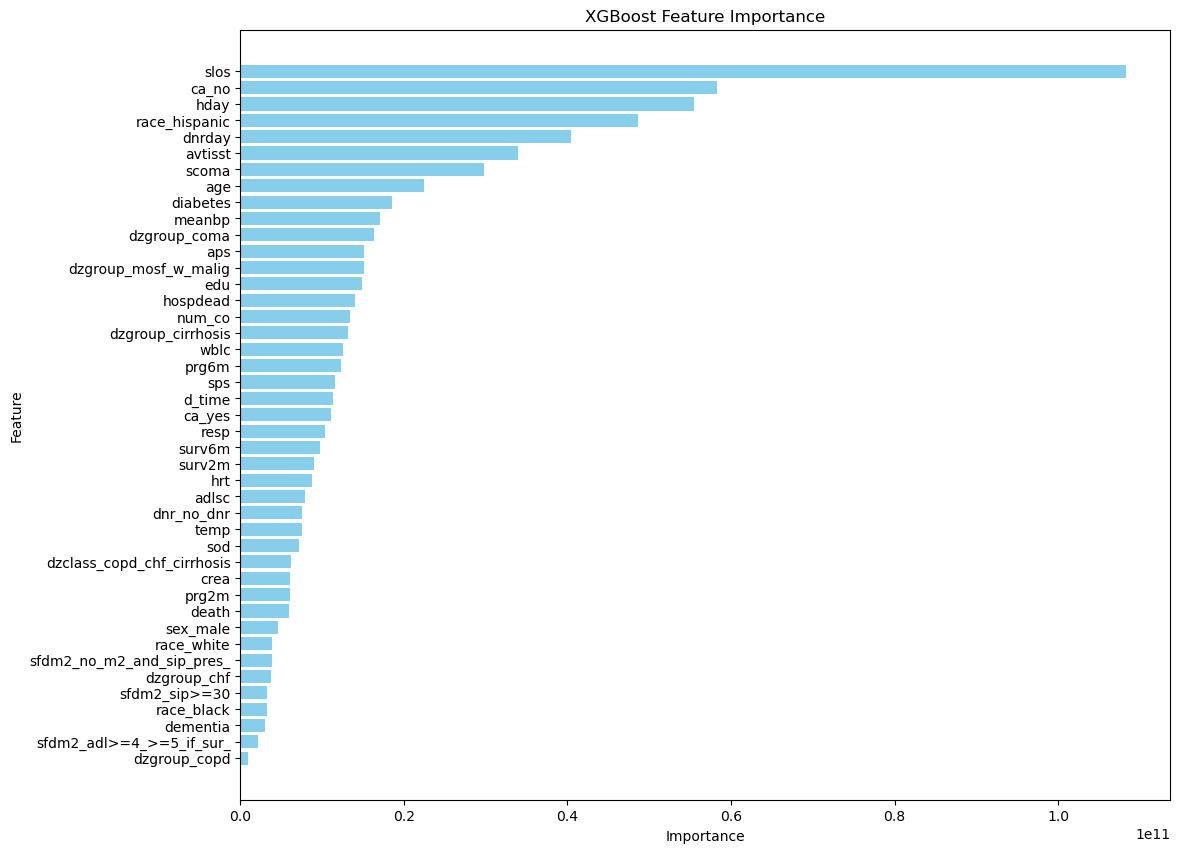

In [62]:
# feature importance by gain: the average gain across all splits the feature is used in
xgb_fi_dict = xgb_best.get_booster().get_score(importance_type = 'gain') # returns a dictionary
#xgb_fi_dict
xgb_fi_df = pd.DataFrame(list(xgb_fi_dict.items()), columns = ['Feature', 'Importance']).sort_values(by = "Importance", ascending = False)

plt.figure(figsize = (12, 10))
plt.barh(xgb_fi_df["Feature"], xgb_fi_df["Importance"], color = 'skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()

xgb_fi_path = os.path.join(plots_dir, 'xgb_fi_plot')
plt.savefig(xgb_fi_path)

plt.show()